In [2]:
import random
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_data = pd.read_csv('train.csv',index_col=0)
test_data = pd.read_csv('test.csv',index_col=0)

In [6]:
train_data = train_data.drop(columns=['country','introelapse','testelapse','surveyelapse','hand'])
test_data = test_data.drop(columns=['country','introelapse','testelapse','surveyelapse','hand'])

In [7]:
train_data.isnull().sum()

Q1             41
Q2             69
Q3             50
Q4             71
Q5             38
             ... 
voted          85
married        82
familysize    319
ASD            89
nerdiness       0
Length: 64, dtype: int64

In [8]:
train_data.dropna(inplace=True)

In [9]:
train_data.isnull().sum().sum()

0

In [10]:
Q_data = train_data.filter(regex='Q',axis=1)
Q_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,5.0,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,1.0
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,4.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,2.0,5.0
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,5.0,3.0,5.0,2.0,2.0,1.0,2.0,4.0,2.0,5.0
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,4.0,5.0,4.0,3.0,3.0,4.0,3.0,4.0,4.0,2.0
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,4.0,1.0,4.0,2.0,4.0,2.0,3.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,...,2.0,5.0,2.0,4.0,1.0,2.0,5.0,4.0,2.0,4.0
14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,...,5.0,4.0,1.0,5.0,3.0,4.0,4.0,5.0,4.0,5.0
14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,...,5.0,5.0,4.0,5.0,5.0,2.0,5.0,5.0,3.0,4.0


<AxesSubplot:>

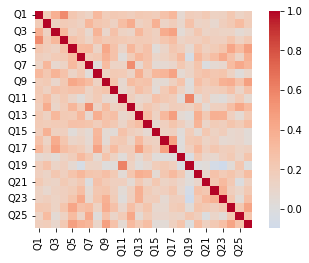

In [12]:
import seaborn as sns
Q_cor = Q_data.corr(method='spearman')
sns.heatmap(Q_cor, cmap='coolwarm', square=True, center=0)

In [13]:
train_data['Mach_score'] = Q_data.mean(axis=1)
train_data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,religion,orientation,voted,married,familysize,ASD,nerdiness,Mach_score
index,,,,,,,,,,,,,,,,,,,,,
0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,3.0,...,1.0,20,12.0,4.0,2.0,1.0,4.0,2.0,1,3.653846
1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,...,1.0,49,2.0,1.0,1.0,2.0,4.0,2.0,1,3.269231
2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,4.0,...,2.0,43,2.0,2.0,2.0,3.0,4.0,2.0,1,3.692308
3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,4.0,...,1.0,17,1.0,1.0,2.0,1.0,2.0,2.0,1,3.500000
4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,4.0,...,2.0,18,12.0,1.0,2.0,1.0,1.0,2.0,0,3.461538


In [14]:
train_data[['Mach_score']].describe()

,Mach_score
count,12817.000000
mean,3.706033
std,0.581896
min,1.000000
25%,3.346154
50%,3.730769
75%,4.115385
max,5.000000
